In [1]:
import numpy as np 
import pandas as pd 
import h5py 
import scipy as sp 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.integrate as spi

from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm

from ipywidgets import interact, interact_manual,fixed
from ipywidgets import widgets # Widget definitions
from IPython.display import display, HTML, Math, Latex # Used to display widgets in the notebook

from scipy.interpolate import interp1d


%matplotlib inline 

In [2]:
figname='lt'
h5file=h5py.File("/Users/pablo/Development/PostNewton3BP/exe/Fig3_"+figname+"/output.h5")

In [3]:


def get_dynamic_variable(h5file, dataset):
    Np=h5file['0'][dataset].attrs['np'][0]
    Dim=h5file['0'][dataset].attrs['dim'][0]
    coord=['x','y','z']    
    cols=['t']
    for p in np.arange(Np):
        for i in np.arange(Dim):
            cols.append(coord[i]+str(p+1))
    df=pd.DataFrame(h5file['0'][dataset][:],columns=cols)
    if Dim ==2:
        for p in np.arange(Np):
            df['z'+str(p+1)]=0
        return df.reindex_axis(sorted(df.columns),axis=1)
    return df

df_x=get_dynamic_variable(h5file, "position").set_index('t')
df_p=get_dynamic_variable(h5file, "momentum").set_index('t')

df_dxdt=get_dynamic_variable(h5file, "dxdt").set_index('t')
df_dpdt=get_dynamic_variable(h5file, "dpdt").set_index('t')

df_ddxdt2=get_dynamic_variable(h5file, "ddxdt2").set_index('t')
df_ddpdt2=get_dynamic_variable(h5file, "ddpdt2").set_index('t')

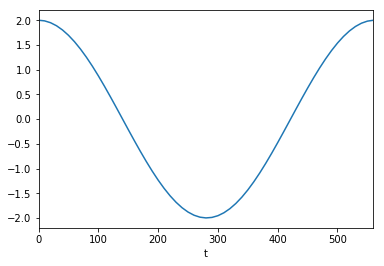

In [4]:
#ax=df_x[df_x.index < 693.80892429].plot.scatter(x='x1',y='y1',s=1,c='g')
#ax=df_x[df_x.index < 693.80892429].plot.scatter(x='x2',y='y2',s=1,c='b',ax=ax)
df_x[df_x.index < 561.9852286]['x1'].plot()

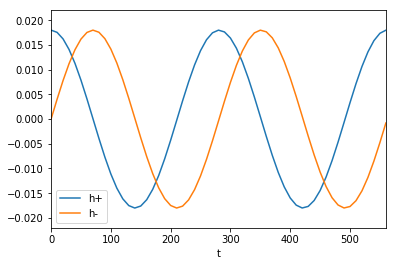

In [5]:
m=h5file['0/position'].attrs['mass']
num_part=h5file['0/position'].attrs['np'][0]
coords=['x','y','z']  
p1_coords=[x+'1' for x in coords]
p2_coords=[x+'2' for x in coords]



p_idx=np.arange(num_part)
d_idx=np.arange(3)
p_cols=[[ axis+str(a+1) for axis in coords] for a in p_idx]
t_list=df_x.index
X=np.array([500,0,0])

aa=np.sqrt((df_x['x1']-df_x['x2'])**2+(df_x['y1']-df_x['y2'])**2+(df_x['z1']-df_x['z2'])**2)
L=pd.DataFrame(np.cross(df_x[p1_coords],df_p[p1_coords]),index=t_list,columns=p1_coords)
w=np.linalg.norm(L,axis=1)/(m[0]*np.linalg.norm(df_x[p1_coords],axis=1)**2)
df_ref=pd.DataFrame({
    'h+':4*m[0]*m[1]*np.cos(2*w*t_list)/(aa),'t':t_list,
    'h-':4*m[0]*m[1]*np.sin(2*w*t_list)/(aa),'t':t_list
}).set_index('t')
df_ref[df_ref.index<561.98522868].plot(ylim=(-0.022,0.022))


In [6]:
dx_interpolation=dict()
dp_interpolation=dict()
for cx,cp in zip(df_x.columns,df_p.columns):
    dx_interpolation[cx]=interp1d(df_x.index, df_x[cx], kind='cubic')
    dp_interpolation[cp]=interp1d(df_p.index, df_p[cp], kind='cubic')

In [7]:
tr0_dict=dict()
tr1_dict=dict()
tr2_dict=dict()
tr3_dict=dict()
time_dict=dict()


for t in t_list:
    row_tr0_dict=dict()
    row_tr1_dict=dict()
    row_tr2_dict=dict()
    row_tr3_dict=dict()
    row_time_dict=dict()

    for a in p_idx:
                
        ra=np.linalg.norm(X-df_x.loc[t][p_cols[a]])
        row_tr0_dict[('r',a)]=ra
        pa=df_p.loc[t][p_cols[a]]
        row_tr0_dict[('p2',a)]=pa.dot(pa)
        t_ret=t-ra
        row_tr0_dict[('t_ret',a)]=t_ret
        
        for tt in t_list:
            row_time_dict[(a,tt)]=t>=tt and tt>t_ret
        time_dict[t]=row_time_dict


        if t_ret >0:
            x_ret = np.array([dx_interpolation[p_cols[a][axis]](t_ret) for  axis in d_idx])
            p_ret = np.array([dp_interpolation[p_cols[a][axis]](t_ret) for  axis in d_idx])
            ra_ret=np.linalg.norm(X-x_ret)
            row_tr0_dict[('r_ret',a)]=ra_ret
            row_tr0_dict[('p2_ret',a)]=p_ret.dot(p_ret)
       
        nv=[]
        for axis in d_idx:
            xx=df_x.loc[t][p_cols[a][axis]]
            row_tr1_dict[('p',coords[axis],a)]=pa[axis]
            row_tr1_dict[('x',coords[axis],a)]=xx
            ra_i=X[axis]-xx 
            row_tr1_dict[('r',coords[axis],a)]=ra_i
            nv.append(ra_i/ra)
            row_tr1_dict[('n',coords[axis],a)]=nv[-1]
            
            if t_ret >0:
                      
                row_tr1_dict[('x_ret',coords[axis],a)]=x_ret[axis]
                row_tr1_dict[('p_ret',coords[axis],a)]=p_ret[axis]
                ra_ret_i=X[axis]-x_ret[axis] 
                row_tr1_dict[('r_ret',coords[axis],a)]=ra_ret_i      
                row_tr1_dict[('n_ret',coords[axis],a)]=ra_ret_i/ra_ret
       
        row_tr0_dict[('n.p',a)]=pa.dot(nv)
            
        for b in p_idx:
            if a == b:
                continue
            rab=np.linalg.norm(df_x.loc[t][p_cols[a]].values-df_x.loc[t][p_cols[b]].values)
            row_tr2_dict[('r',a,b)]=rab
                    
            rb=np.linalg.norm(X-df_x.loc[t][p_cols[b]])
            row_tr2_dict[('s',a,b)]=rab+ra+rb

            if t_ret >0:
                xb_ret = np.array([dx_interpolation[p_cols[b][axis]](t_ret) for  axis in d_idx])
                rab_ret=np.linalg.norm(x_ret-xb_ret)
                row_tr2_dict[('r_ret',a,b)]=rab_ret
            
            for axis in d_idx:
                rab_i=df_x.loc[t][p_cols[a][axis]]-df_x.loc[t][p_cols[b][axis]]
                row_tr3_dict[('r',coords[axis],a,b)]=rab_i
                row_tr3_dict[('n',coords[axis],a,b)]=rab_i/rab if rab !=0 else np.nan
                
                if t_ret >0:
                    rab_ret_i=x_ret[axis]-xb_ret[axis]
                    row_tr3_dict[('r_ret',coords[axis],a,b)]=rab_ret_i
                    row_tr3_dict[('n_ret',coords[axis],a,b)]=rab_ret_i/rab_ret if rab_ret !=0 else np.nan
            
            
    tr0_dict[t]=row_tr0_dict
    tr1_dict[t]=row_tr1_dict
    tr2_dict[t]=row_tr2_dict
    tr3_dict[t]=row_tr3_dict
    
    
df_tr0=pd.DataFrame(tr0_dict).T
df_tr1=pd.DataFrame(tr1_dict).T
df_tr2=pd.DataFrame(tr2_dict).T
df_tr3=pd.DataFrame(tr3_dict).T
df_time=pd.DataFrame(time_dict).T

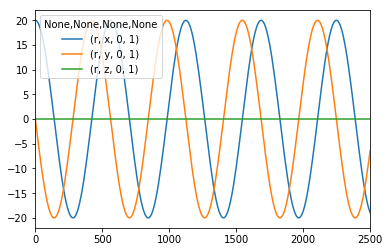

In [8]:
df_tr3.loc[:,('r',slice(None),0,1)].plot()

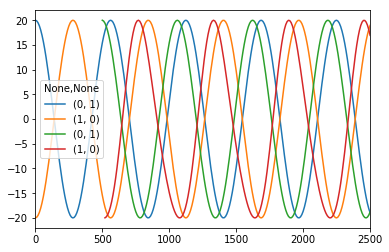

In [9]:
ax=df_tr3['r']['x'].plot()
df_tr3['r_ret']['x'].plot(ax=ax)

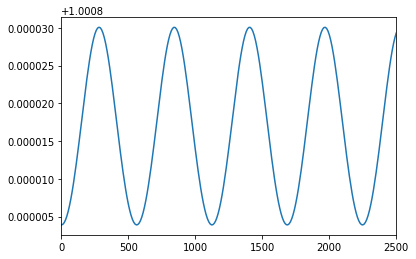

In [10]:
phi2= 4*(m[a]/df_tr0['r']).sum(axis=1)
phi4= 2*(df_tr0['p2']/(m[a]*df_tr0['r'])).sum(axis=1) 
psi=(1+0.125*(phi2+phi4))**4
psi.plot()

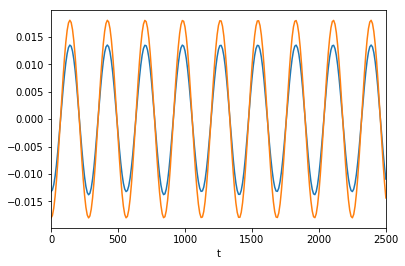

In [11]:


def hTT4(i,j):


    term1=(2*df_tr1['p',coords[i]]*df_tr1['p',coords[j]]\
            +(3*df_tr0['n.p']**2-5*df_tr0['p2'])*df_tr1['n',coords[i]]*df_tr1['n',coords[j]]\
            +6*df_tr0['n.p']*(df_tr1['n',coords[i]]*df_tr1['p',coords[j]]+df_tr1['n',coords[j]]*df_tr1['p',coords[i]]))/(m*df_tr0['r'])
    if i==j:
        term1+=(df_tr0['p2']-5*df_tr0['n.p']**2)/(df_tr0['r']*m)

    term2=0
    for a in p_idx:
        for b in p_idx:
            if a == b:
                continue
            term2+= m[a]*m[b]*(-32*(1./df_tr2['r',a,b]+1./df_tr2['s',a,b])*df_tr3['n',coords[i],a,b]*df_tr3['n',coords[j],a,b]/df_tr2['s',a,b]\
                    +2*( (df_tr0['r',a]+df_tr0['r',b])/df_tr2['r',a,b]**3+12./df_tr2['s',a,b]**2)*df_tr1['n',coords[i],a]*df_tr1['n',coords[j],b]
                    +16*(2./df_tr2['s',a,b]**2-1./df_tr2['r',a,b]**2)*(df_tr1['n',coords[i],a]*df_tr3['n',coords[j],a,b]+df_tr1['n',coords[j],a]*df_tr3['n',coords[i],a,b])
                    +(5./(df_tr2['r',a,b]*df_tr0['r',a])-(df_tr0['r',b]**2/df_tr0['r',a]+3*df_tr0['r',a])/df_tr2['r',a,b]**3-8*(1./df_tr0['r',a]+1./df_tr2['s',a,b])/df_tr2['s',a,b])*df_tr1['n',coords[i],a]*df_tr1['n',coords[j],a])
            if i==j:
                term2+=m[a]*m[b]*(5*df_tr0['r',a]*(df_tr0['r',a]/df_tr0['r',b]-1)/df_tr2['r',a,b]**3-17./(df_tr2['r',a,b]*df_tr0['r',a])+4./(df_tr0['r',a]*df_tr0['r',b])+8*(1./df_tr0['r',a]+4./df_tr2['r',a,b])/df_tr2['s',a,b])
                        
    return 0.25*term1.sum(axis=1)+0.125*term2

df_hTT4=hTT4(0,0)

ax=None
ax=(sp.linalg.norm(X)*hTT4(0,0)).plot()
#ax=hTT4(1,1).plot(ax=ax)
#ax=hTT4(2,2).plot(ax=ax)
#df_hTT4.plot(ax=ax)
(-df_ref['h+']).plot(ax=ax)


In [12]:
def intHTT(t,t_ret,u,a,indx,i,j):    
    tau=np.insert(df_tr0.index[indx],0,t_ret)
    ra=pd.concat([pd.Series({t_ret:df_tr0.loc[t,'r_ret'][a]}) ,df_tr0[indx]['r'][a]])
    na=pd.concat([pd.DataFrame({t_ret:df_tr1.loc[t,'n_ret'].xs(a,axis=0,level=1)}).T ,df_tr1[indx]['n'].xs(a,axis=1,level=1)])
    u2=(u*u).sum(axis=1)
    u_na=(u*na).sum(axis=1)
#    print(u2,u)
    arg1=6*u[coords[i]]*u[coords[j]]\
        -6*u_na*(u[coords[i]]*na[coords[j]]+u[coords[j]]*na[coords[i]])\
        +(9*u2-15*u_na**2)*na[coords[i]]*na[coords[j]]
    
    arg2=2*u[coords[i]]*u[coords[j]]\
        -10*u_na*(u[coords[i]]*na[coords[j]]+u[coords[j]]*na[coords[i]])\
        +(-5*u2+35*u_na**2)*na[coords[i]]*na[coords[j]]

    if i==j:
        arg1+=-5*u2+9*u_na**2
        arg2+=u2-5*u_na**2

    arg1*=(t-tau)/ra**3
    arg2*=(t-tau)**3/ra**5

    return -spi.simps(arg1+arg2,x=tau)
            

In [13]:
def hTT_ret(i,j,u,u_ret,a):
    na=df_tr1['n'].xs(a,axis=1,level=1)
    u_na=(u*na).sum(axis=1)
    u2=(u*u).sum(axis=1)

    na_ret=df_tr1['n_ret'].xs(a,axis=1,level=1)
    u_na_ret=(u_ret*na_ret).sum(axis=1)
    u2_ret=(u_ret*u_ret).sum(axis=1)
    ht=0
    ht_ret=0
    if i==j:
        ht+=u2-5*u_na**2
        ht_ret+=-2*u2_ret+2*u_na_ret**2
    ht+=2*u[coords[i]]*u[coords[j]]\
        +(3*u_na**2-5*u2)*na[coords[i]]*na[coords[j]]\
        +6*u_na*(u[coords[i]]*na[coords[j]]+u[coords[j]]*na[coords[i]])
    ht/=df_tr0['r',a]
    
    ht_ret+=4*u_ret[coords[i]]*u_ret[coords[j]]\
            +(2*u_na_ret**2+2*u2_ret)*na_ret[coords[i]]*na_ret[coords[j]]\
            -4*u_na_ret*(u_ret[coords[i]]*na_ret[coords[j]]+u_ret[coords[j]]*na_ret[coords[i]])  
    ht_ret/=df_tr0['r_ret',a]
    
    return -0.25*ht+ht_ret

def HTT4(i,j):
    
    term3=0
    for a in p_idx:
        term3+=hTT_ret(i,j,df_tr1['p'].xs(a,axis=1,level=1)/np.sqrt(m[a]),df_tr1['p_ret'].xs(a,axis=1,level=1)/np.sqrt(m[a]),a)

        for b in p_idx:
            if a == b :
                continue
            term3-=hTT_ret(i,j,df_tr3['n'].xs(a,axis=1,level=1).xs(b,axis=1,level=1).mul(np.sqrt(0.5*m[a]*m[b]/df_tr2['r',a,b]),axis=0),df_tr3['n_ret'].xs(a,axis=1,level=1).xs(b,axis=1,level=1).mul(np.sqrt(0.5*m[a]*m[b]/df_tr2['r_ret',a,b]),axis=0),a)

    data_list=list()
    for t in df_time.index:
        result=0
        for a in p_idx:
            indx=df_time.loc[t][a]
            t_ret=df_tr0.loc[t,('t_ret',a)]
            if t_ret <0:
                result=np.nan
                continue
            df_u=pd.concat([pd.DataFrame({t_ret:df_tr1.loc[t,'p_ret'].xs(a,axis=0,level=1)/np.sqrt(m[a])}).T ,df_tr1[indx]['p'].xs(a,axis=1,level=1)])
            result+=intHTT(t,t_ret,df_u,a,indx,i,j)
            for b in p_idx:
                if a==b:
                    continue
                df_u0=df_tr3[indx]['n'].xs(a,axis=1,level=1).xs(b,axis=1,level=1).mul(np.sqrt(0.5*m[a]*m[b]/df_tr2[indx]['r',a,b]),axis=0)
                df_u1=df_tr3.loc[t,'n_ret'].xs(a,axis=0,level=1).xs(b,axis=0,level=1).mul(np.sqrt(0.5*m[a]*m[b]/df_tr2.loc[t]['r_ret',a,b]),axis=0)
                df_u=pd.concat([pd.DataFrame({t_ret:df_u1}).T ,df_u0])
                result+=intHTT(t,t_ret,df_u,a,indx,i,j)

        data_list.append({'t':t,'hTT4ret_'+str(i)+str(j):result})
    return pd.concat([pd.DataFrame(data_list).set_index('t'),term3],axis=1)

df_HTT=HTT4(0,0)

In [14]:
df_HTT

,hTT4ret_00,0
t,,
0.00,NaN,NaN
10.01,NaN,NaN
20.01,NaN,NaN
30.01,NaN,NaN
40.01,NaN,NaN
50.01,NaN,NaN
60.01,NaN,NaN
70.01,NaN,NaN
80.01,NaN,NaN


In [15]:
df_wave=pd.DataFrame({'hTT4':-hTT4(0,0),'HTT_int':df_HTT[0],'HTT_ret':df_HTT[0],'psi':psi})

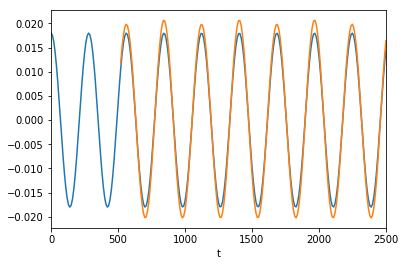

In [16]:
ax=df_ref['h+'].plot()
(sp.linalg.norm(X)*df_wave[['HTT_ret','hTT4','HTT_int']].apply(lambda x : -x[1]+x[0]+x[2],axis=1,raw=True)/2).plot(ax=ax)

In [ ]:
m=h5file['0/position'].attrs['mass']
num_part=h5file['0/position'].attrs['np'][0]
dim=h5file['0/position'].attrs['dim'][0]


def phi(xx,yy,zz,x,m,mR2,P2):
    X=np.array([xx,yy,zz])
    R1=X-x
    mR1=np.linalg.norm(R1,axis=1)
    phi2= 4*np.sum([m[a]/mR1[a] for a in p_idx ])
    phi4= 2*np.sum([P2[a]/(m[a]*mR1[a]) for a in p_idx])-2*np.sum([np.sum([0 if a==b else m[a]*m[b]/(mR1[a]*mR2[a,b]) for a in p_idx ]) for b in p_idx])

    return phi2+phi4


def HTT_ret(ra,ra_ret,uv,uv_ret,nv,nv_ret,i,j):
    un2=uv.dot(nv)**2
    un2_ret=uv_ret.dot(nv_ret)**2
    u2=uv.dot(uv)
    u2_ret=uv_ret.dot(uv_ret)
    result_t=0
    result_tret=0
    if(i==0):
        result_t+=u2-5*un2
        result_tret+=-2*u2_ret+2*un2_ret
    result_t+=2*uv[i]*uv[j]+nv[i]*nv[j]*(3*un2-5*u2)+12*uv.dot(nv)*(uv[i]*nv[j]+uv[j]*nv[i])
    result_tret+=4*uv_ret[i]*uv_ret[j]+nv_ret[i]*nv_ret[j]*(2*u2_ret+2*un2_ret)-8*uv_ret.dot(nv_ret)*(uv_ret[i]*nv_ret[j]+uv_ret[j]*nv_ret[i])
    return -0.25*result_t/ra+result_tret/ra_ret


def intHTT(tau,t,R1):
    return spi.simps((t-tau)/R1**3,x=tau)

def hTT(xx,yy,zz,x,p,m,mR2,n2,P2,i,j,df_x,df_p,t):
    dij=1 if i==j else 0
    X=np.array([xx,yy,zz])
    R1=X-x
    mR1=np.linalg.norm(R1,axis=1)
    n1=np.array([R1[a]/mR1[a] for a in p_idx])
    s1=0
    t_ret=t-mR1
    if np.all(t_ret>0):
        t_min=[df_x.index[df_x.index<t_ret[a]][-1] for a in p_idx]
        t_max=[df_x.index[df_x.index>=t_ret[a]][0] for a in p_idx]
        
        x_ret=np.array([ lin_interpolation(tm,t_ret[a],tM,df_x.loc[tm].values.reshape((3,num_part)).T[a],df_x.loc[tM].values.reshape((3,num_part)).T[a]) for tm,tM,a in zip(t_min,t_max,p_idx)])
        p_ret=np.array([ lin_interpolation(tm,t_ret[a],tM,df_p.loc[tm].values.reshape((3,num_part)).T[a],df_p.loc[tM].values.reshape((3,num_part)).T[a]) for tm,tM,a in zip(t_min,t_max,p_idx)])

        R1_ret=X-x_ret
        mR1_ret=np.linalg.norm(R1_ret,axis=1)
        n1_ret=np.array([R1_ret[a]/mR1_ret[a] for a in p_idx])

        R2_ret=np.array([[x_ret[b]-x_ret[a] for a in p_idx] for b in p_idx])
        mR2_ret=np.linalg.norm(R2_ret,axis=2)
        n2_ret=np.array([[ np.zeros_like(R2_ret[a,b]) if a==b else R2_ret[a,b]/mR2_ret[a,b] for a in p_idx] for b in p_idx])

        tau=[df_x.index[ (df_x.index>=t_ret[a]) *(df_x.index <= t)] for a in p_idx]
        x_tau=[[df_x.loc[tt].values.reshape((3,num_part)).T[a] for tt in tau[a] ] for a in p_idx]
        R1_tau=[[ X-x_tau[a][tt] for tt in np.arange(len(tau[a])) ] for a in p_idx]
        mR1_tau=[[ np.linalg.norm(R1_tau[a][tt]) for tt in np.arange(len(tau[a])) ] for a in p_idx]
        
    hret=0
    for a in p_idx:
        s1+=dij*(P2[a]-5*n1[a].dot(p[a]))+2*p[a,i]*p[a,j] + n1[a,i]*n1[a,j]*(3*(n1[a].dot(p[a]))**2 -5*P2[a])+12*(n1[a].dot(p[a])*(n1[a,i]*p[a,j]+n1[a,j]*p[a,i]))
        s1/=4*(m[a]*mR1[a])
        
        if np.all(t_ret>0):
            hret+=HTT_ret(mR1[a],mR1_ret[a],p[a]/np.sqrt(m[a]),p_ret[a]/np.sqrt(m[a]),n1[a],n1_ret[a],i,j)
            print(intHTT(tau[a],t,np.array(mR1_tau[a])))
            
        s2=0
        for b in p_idx:
            if a==b:
                continue
            s_ab=mR1[a]+mR1[b]+mR2[a,b]
            s2+= -32*n2[a,b,i]*n2[a,b,j]*(1.0/mR2[a,b]+1.0/s_ab)/s_ab+2*n1[a,i]*n1[a,j]*((mR1[a]+mR1[b])/mR2[a,b]**3+12/s_ab**2)
            s2+= 32*(n1[a,i]*n2[a,b,j]+n1[a,j]*n2[a,b,i])*(2.0/s_ab**2-1.0/mR2[a,b]**2) + n1[a,i]*n1[a,j]*(5.0/(mR2[a,b]*mR1[a])-(mR1[b]**2/mR1[a]+3*mR1[a])/mR2[a,b]**3 - 8*(1.0/mR1[a]+1.0/s_ab)/s_ab)
            s2+= dij*(5*mR1[a]*(mR1[a]/mR1[b]-1)/mR2[a,b]**3 - 17.0/(mR2[a,b]*mR1[a]) + 4.0/(mR1[a]*mR1[b]) + 8*(1.0/mR1[a]+4.0/mR2[a,b])/s_ab )
            s2*=m[a]*m[b]*0.125

            if np.all(t_ret>0):
                hret-=HTT_ret(mR1[a],mR1_ret[a],np.sqrt(0.5*m[a]*m[b]/mR2[a,b])*n2[a,b],np.sqrt(0.5*m[a]*m[b]/mR2_ret[a,b])*n2_ret[a,b],n1[a],n1_ret[a],i,j)

    return s1+s2+hret

nx=64
ny=64
nz=4

L=[200,200,1]
C=[0,0,0]

xx=np.linspace(start=C[0]-L[0]/2.,stop=C[0]+L[0]/2.,num=nx)
yy=np.linspace(start=C[1]-L[1]/2.,stop=C[1]+L[1]/2.,num=ny)
zz=np.linspace(start=C[2]-L[2]/2.,stop=C[2]+L[2]/2.,num=nz)
X,Y,Z =np.meshgrid(xx,yy,zz)


t_list=df_x.index


In [ ]:
xc=100
yc=0
zc=0

dump_list=list()
for t in t_list:
    x=df_x.loc[t].values.reshape((3,num_part)).T
    p=df_p.loc[t].values.reshape((3,num_part)).T
        
    P2=np.array([p[a].dot(p[a]) for a in p_idx])
    
    R2=np.array([[x[b]-x[a] for a in p_idx] for b in p_idx])
    mR2=np.linalg.norm(R2,axis=2)
    
    n2=np.array([[ np.zeros_like(R2[a,b]) if a==b else R2[a,b]/mR2[a,b] for a in p_idx] for b in p_idx])
    
    Phi=phi(xc,yc,zc,x,m,mR2,P2)
    Htt_11=hTT(xc,yc,zc,x,p,m,mR2,n2,P2,0,0,df_x,df_p,t)
    
    Psi4=(1+0.125*Phi)**4
    dump_list.append({"psi4":Psi4,"t":t,'hTT_00':Htt_11})


In [ ]:
df_wave=pd.DataFrame(dump_list)

In [ ]:
df_tr1['r'].xs(1,axis=1,level=1).div(df_tr1['r'].xs(1,axis=1,level=1).sum(axis=1),axis=0)-df_tr1['n'].xs(1,axis=1,level=1)

In [ ]:
df_tr0['n.p'] #.xs(0,axis=1,level=1).apply(np.linalg.norm,axis=1)

In [ ]:
dump_list=list()
for t in t_list:
    x=df_x.loc[t].values.reshape((3,num_part)).T
    p=df_p.loc[t].values.reshape((3,num_part)).T
        
    P2=np.array([p[a].dot(p[a]) for a in p_idx])
    
    R2=np.array([[x[b]-x[a] for a in p_idx] for b in p_idx])
    mR2=np.linalg.norm(R2,axis=2)
    n2=np.array([[ np.zeros_like(R2[a,b]) if a==b else R2[a,b]/mR2[a,b] for a in p_idx] for b in p_idx])
    
    Phi=list()
    Htt_11=list()
    for xc,yc,zc in zip(X.flatten(),Y.flatten(),Z.flatten()):
        Phi.append(phi(xc,yc,zc,x,m,mR2,P2))
        Htt_11.append(hTT(xc,yc,zc,x,p,m,mR2,n2,P2,0,0,df_x,df_p,t))
    df_phi=pd.DataFrame({'x':X.flatten(),'y':Y.flatten(),'z':Z.flatten(),'phi':Phi,'hTT_00':Htt_11})

    z_val=df_phi['z'].abs().max()
    df_z=df_phi.query('z=='+str(z_val))
    Psi4=(1+0.125*df_z['phi'].values.reshape(nx,ny))**4
    dump_list.append({"psi4":Psi4,"t":t,'hTT_00':df_z['hTT_00'].values.reshape(nx,ny)})

In [ ]:
def plot_dump(t):
#    fig = plt.figure(figsize=(10,5))
#    ax = fig.add_subplot(111, projection='3d')
#    ax.plot_wireframe(X[:,:,0], Y[:,:,0], np.log(dumps_list[t]['z']), rstride=1, cstride=1)
    plt.imshow(dump_list[t]['hTT_00'], extent=(np.min(xx), np.max(xx), np.min(yy), np.max(yy)),
        cmap=cm.hot)
    plt.show()
d=interact(plot_dump,t=widgets.IntSlider(min=0,max=len(dump_list)-1,continuous_update=True))

In [ ]:
grid_size=h5file['coordinates/x'].shape
xc=h5file['coordinates/x'][:,:,grid_size[2]/2]
yc=h5file['coordinates/y'][:,:,grid_size[2]/2]

r_indx=np.sqrt(xc**2+yc**2) < 25

dumps_len=len(h5file['0/fields'].keys())
metric=[h5file['0/fields/'+str(i)+'/metric_0_0'][:,:,grid_size[2]/2] for i in np.arange(dumps_len)]

def plot_metric_map(i):
    data=metric[i]
    data[r_indx]=1
    plt.imshow(data, extent=(np.amin(xc), np.amax(xc), np.amin(yc), np.amax(yc)),
            cmap=cm.hot, norm=LogNorm())
    plt.colorbar()
    plt.show()
    

In [ ]:
d=interact(plot_metric_map,i=widgets.IntSlider(max=dumps_len-1))

In [ ]:
def get_waves(h5file):
    l_modes=[2,3] 
    columns=["t"]
    name=["Q","O","CQ"]
    for l in l_modes:
        for p in ['R','I']:
            for m in np.arange(start=-l,stop=l+1):
                columns.append(p+'['+name[l-2]+'m='+str(m)+"]")
    l=3
    for p in ['R','I']:
        for m in np.arange(start=-l,stop=l+1):
            columns.append(p+'['+name[l-1]+'m='+str(m)+"]")
    return pd.DataFrame(h5file['0']['waves'][:],columns=columns)       
    
df_waves2=get_waves(h5file).set_index('t')

In [ ]:
df_waves2['R[Qm=2]'].plot(figsize=(20,10))

In [ ]:
ax=(0.625*df_waves2['R[Qm=2]']).plot(figsize=(20,10))
ax=(9.5*df_hTT4).plot(ax=ax)
df_ref['h+'].plot(ax=ax)